In [1]:
#imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#set ups
plt.rcParams['figure.figsize'] = (12, 10)

#data
PATH = '../data/wine.csv'
wine = pd.read_csv(PATH)
wine.drop("index",inplace=True,axis=1)

# Dataframe Modif

In [2]:
wine_modif = wine.copy()

### Total Sulfur Dioxide - [Why it Matters, Too!](https://www.extension.iastate.edu/wine/total-sulfur-dioxide-why-it-matters-too#:~:text=Simply%20put%2C%20Total%20Sulfur%20Dioxide,aldehydes%2C%20pigments%2C%20or%20sugars.)

In [3]:
#ratio TSO2 /FSO2
wine_modif["ratioSO2"] = wine_modif["free sulfur dioxide"] / wine_modif["total sulfur dioxide"]

In [4]:
# Creating a test/train split
index_sep = 0.80
split_index = int(wine_modif.shape[0] * index_sep)

train_features = wine_modif[:split_index]
test_features = wine_modif[split_index:]

# Features selection
X_train = train_features.drop(['quality'], axis = 1).values
X_test = test_features.drop(['quality'], axis = 1).values

#Target = Quality
target = pd.get_dummies(wine_modif['quality']).values # One hot encode
train_target = target[:split_index]
test_target = target[split_index:]

In [5]:
X_train

array([[ 7.4       ,  0.7       ,  0.        , ...,  0.56      ,
         9.4       ,  0.32352941],
       [ 7.8       ,  0.88      ,  0.        , ...,  0.68      ,
         9.8       ,  0.37313433],
       [ 7.8       ,  0.76      ,  0.04      , ...,  0.65      ,
         9.8       ,  0.27777778],
       ...,
       [ 7.2       ,  0.16      ,  0.29      , ...,  0.4       ,
        12.1       ,  0.32520325],
       [ 6.6       ,  0.17      ,  0.28      , ...,  0.52      ,
        11.9       ,  0.50925926],
       [ 6.6       ,  0.19      ,  0.28      , ...,  0.37      ,
        10.8       ,  0.39416058]])

# Normalize the data

In [6]:
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test  -= mean
std = np.std(X_train, axis=0)
X_train /= std
X_test /= std

# Plot function

In [7]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color="red", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color="blue", linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    
    plt.legend()

### Class weights

In [8]:
labels = wine_modif['quality'].values
y_w = labels[:split_index]

In [9]:
from sklearn.utils import class_weight
class_weights = dict(zip([0,1,2,3,4,5,6], class_weight.compute_class_weight(None, classes = np.unique(y_w), 
                y=y_w))) 

# Model

In [10]:
input_shape = (X_train.shape[1],)
output_shape = len(wine["quality"].unique()) # number of output node

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None,output_shape=output_shape,input_shape=input_shape):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(60,activation="sigmoid",input_shape=input_shape),
      keras.layers.Dense(30, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(output_shape, activation='softmax')
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.CategoricalCrossentropy(),
      metrics=metrics)

  return model

In [12]:
EPOCHS = 30
BATCH_SIZE = 2500
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_aux', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
weighted_model = make_model()
weighted_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                780       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1830      
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 217       
Total params: 2,827
Trainable params: 2,827
Non-trainable params: 0
_________________________________________________________________


## Model Testing

In [14]:

weighted_history = weighted_model.fit(
    X_train,
    train_target,
    batch_size=BATCH_SIZE,
    epochs=50,
    callbacks=[early_stopping],
    validation_split=0.3,
    # The class weights go here
    class_weight=class_weights)


Epoch 1/50
2/2 [==============================] - 4s 1s/step - loss: 1.8578 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 19548.0000 - fn: 3258.0000 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6354 - val_loss: 1.7351 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 9360.0000 - val_fn: 1560.0000 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7241
Epoch 2/50
2/2 [==============================] - 0s 148ms/step - loss: 1.7566 - tp: 0.6667 - fp: 0.6667 - tn: 19547.3333 - fn: 3257.3333 - accuracy: 0.8571 - precision: 0.3333 - recall: 1.8330e-04 - auc: 0.6949 - val_loss: 1.6629 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 9360.0000 - val_fn: 1560.0000 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7940
Epoch 3/50
2/2 [==============================] - 0s 168ms/step - loss: 1.6824 - tp: 8.0000 - fp: 4.6667 - tn: 19543.3333 - fn: 3250.0000 - accuracy: 0.8573 - precision: 0.6389 

Epoch 14/50
2/2 [==============================] - 0s 137ms/step - loss: 1.4053 - tp: 518.3333 - fp: 682.0000 - tn: 18866.0000 - fn: 2739.6667 - accuracy: 0.8499 - precision: 0.4315 - recall: 0.1591 - auc: 0.8318 - val_loss: 1.3328 - val_tp: 1.0000 - val_fp: 11.0000 - val_tn: 9349.0000 - val_fn: 1559.0000 - val_accuracy: 0.8562 - val_precision: 0.0833 - val_recall: 6.4103e-04 - val_auc: 0.8474
Epoch 15/50
2/2 [==============================] - 0s 108ms/step - loss: 1.4135 - tp: 509.0000 - fp: 683.3333 - tn: 18864.6667 - fn: 2749.0000 - accuracy: 0.8495 - precision: 0.4272 - recall: 0.1562 - auc: 0.8286 - val_loss: 1.3278 - val_tp: 1.0000 - val_fp: 11.0000 - val_tn: 9349.0000 - val_fn: 1559.0000 - val_accuracy: 0.8562 - val_precision: 0.0833 - val_recall: 6.4103e-04 - val_auc: 0.8487
Epoch 16/50
2/2 [==============================] - 0s 152ms/step - loss: 1.4026 - tp: 559.3333 - fp: 623.3333 - tn: 18924.6667 - fn: 2698.6667 - accuracy: 0.8543 - precision: 0.4730 - recall: 0.1715 - auc: 

Epoch 27/50
2/2 [==============================] - 0s 148ms/step - loss: 1.3431 - tp: 479.0000 - fp: 483.3333 - tn: 19064.6667 - fn: 2779.0000 - accuracy: 0.8569 - precision: 0.4969 - recall: 0.1465 - auc: 0.8464 - val_loss: 1.2928 - val_tp: 17.0000 - val_fp: 40.0000 - val_tn: 9320.0000 - val_fn: 1543.0000 - val_accuracy: 0.8550 - val_precision: 0.2982 - val_recall: 0.0109 - val_auc: 0.8601
Epoch 28/50
2/2 [==============================] - 0s 130ms/step - loss: 1.3552 - tp: 507.6667 - fp: 540.6667 - tn: 19007.3333 - fn: 2750.3333 - accuracy: 0.8556 - precision: 0.4833 - recall: 0.1555 - auc: 0.8442 - val_loss: 1.2897 - val_tp: 22.0000 - val_fp: 47.0000 - val_tn: 9313.0000 - val_fn: 1538.0000 - val_accuracy: 0.8549 - val_precision: 0.3188 - val_recall: 0.0141 - val_auc: 0.8608
Epoch 29/50
2/2 [==============================] - 0s 134ms/step - loss: 1.3289 - tp: 518.6667 - fp: 503.0000 - tn: 19045.0000 - fn: 2739.3333 - accuracy: 0.8579 - precision: 0.5089 - recall: 0.1597 - auc: 0.8507

Epoch 40/50
2/2 [==============================] - 0s 156ms/step - loss: 1.2981 - tp: 585.6667 - fp: 565.0000 - tn: 18983.0000 - fn: 2672.3333 - accuracy: 0.8579 - precision: 0.5079 - recall: 0.1796 - auc: 0.8573 - val_loss: 1.2562 - val_tp: 47.0000 - val_fp: 68.0000 - val_tn: 9292.0000 - val_fn: 1513.0000 - val_accuracy: 0.8552 - val_precision: 0.4087 - val_recall: 0.0301 - val_auc: 0.8682
Epoch 41/50
2/2 [==============================] - 0s 145ms/step - loss: 1.3010 - tp: 595.6667 - fp: 597.3333 - tn: 18950.6667 - fn: 2662.3333 - accuracy: 0.8569 - precision: 0.4979 - recall: 0.1823 - auc: 0.8562 - val_loss: 1.2539 - val_tp: 57.0000 - val_fp: 77.0000 - val_tn: 9283.0000 - val_fn: 1503.0000 - val_accuracy: 0.8553 - val_precision: 0.4254 - val_recall: 0.0365 - val_auc: 0.8685
Epoch 42/50
2/2 [==============================] - 0s 189ms/step - loss: 1.2869 - tp: 613.6667 - fp: 580.0000 - tn: 18968.0000 - fn: 2644.3333 - accuracy: 0.8587 - precision: 0.5153 - recall: 0.1889 - auc: 0.8600

In [15]:
weighted_model.evaluate(X_test,test_target)

41/41 [==============================] - 0s 2ms/step - loss: 1.1415 - tp: 86.0000 - fp: 69.0000 - tn: 7731.0000 - fn: 1214.0000 - accuracy: 0.8590 - precision: 0.5548 - recall: 0.0662 - auc: 0.8959 


[1.1415090560913086,
 86.0,
 69.0,
 7731.0,
 1214.0,
 0.8590110540390015,
 0.5548387169837952,
 0.06615384668111801,
 0.895861029624939]

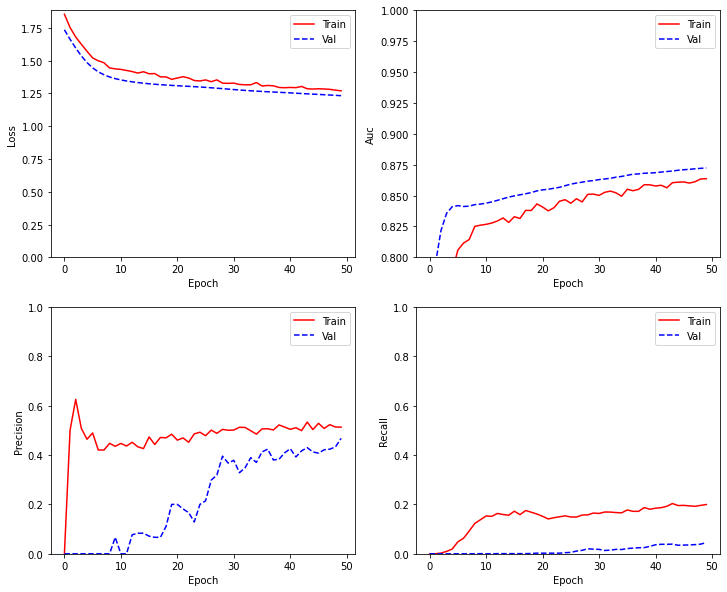

In [16]:
plot_metrics(weighted_history)

In [17]:
data = {
"true_pos": weighted_history.history["tp"],
#"true_neg" :weighted_history.history["tn"],
"fals_pos" : weighted_history.history["fp"],
"false_neg" :weighted_history.history["fn"],
}

In [18]:
measures = pd.DataFrame(data )

<AxesSubplot:>

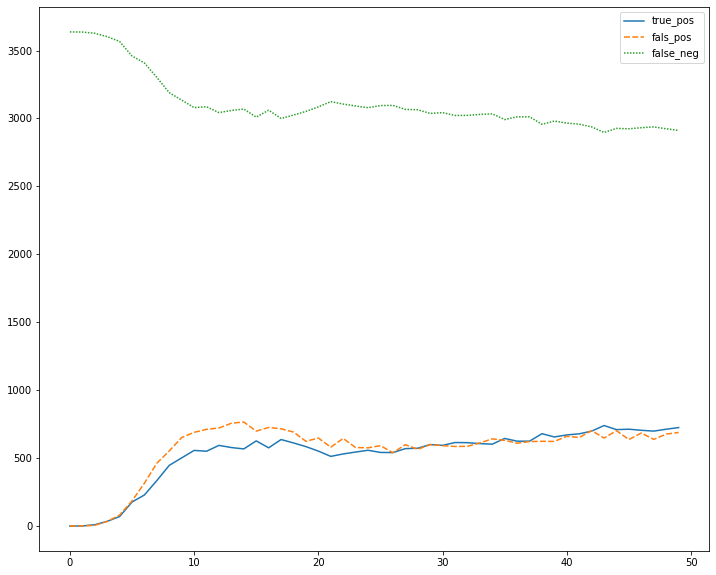

In [19]:
sns.lineplot(data=measures)

In [20]:
pred = weighted_model.predict(X_test)
confusion = confusion_matrix(test_target.argmax(axis=1), pred.argmax(axis=1))
print('Confusion Matrix\n')
confusion

Confusion Matrix



array([[  0,   0,   0,   2,   0,   0],
       [  0,   0,  16,  17,   0,   0],
       [  0,   0, 169, 195,   0,   0],
       [  0,   0, 101, 553,   0,   0],
       [  0,   0,  25, 191,   0,   0],
       [  0,   0,   8,  23,   0,   0]], dtype=int64)

In [21]:
weighted_model.predict(X_test[:5]).argmax(axis=1)

array([3, 2, 3, 3, 3], dtype=int64)

In [22]:
test_target[:5].argmax(axis=1)

array([4, 3, 3, 4, 3], dtype=int64)

# k-Fold Cross-Validating Neural Networks

[method here](https://chrisalbon.com/deep_learning/keras/k-fold_cross-validating_neural_networks/)

In [23]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

In [24]:
neural_network = KerasClassifier(build_fn=make_model,
                                 epochs=30, 
                                 batch_size=2500,
                                 #class_weight=class_weights,
                                 verbose=0)

In [25]:
#features =  wine_modif.drop("quality",axis=1).values
#target = wine_modif["quality"].values

In [26]:
# Evaluate neural network using three-fold cross-validation
cross_val_score(neural_network, X_train, train_target, cv=3)

array([0.85714209, 0.85689467, 0.8565647 ])